In [1]:
import sys

sys.path.insert(0, "../../../submodules/dcegm/src/")

In [2]:
import numpy as np
import jax.numpy as jnp


import seaborn as sns
import matplotlib.pyplot as plt


from elder_care.model import (
    prob_part_time_offer,
    prob_full_time_offer,
    prob_exog_care_demand,
    prob_survival_mother,
    prob_survival_father,
    exog_health_transition_mother,
    exog_health_transition_father,
)

from elder_care.model import utility_func, marginal_utility, inverse_marginal_utility

from elder_care.model import get_state_specific_feasible_choice_set, update_endog_state

from elder_care.model import (
    utility_final_consume_all,
    marginal_utility_final_consume_all,
)


from dcegm.pre_processing.state_space import create_state_space

In [3]:
def _plot_dist(sample):
    sns.histplot(sample, bins=40, kde=True, color="purple")
    # plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.title("Distribution")
    plt.show()

In [4]:
MIN_AGE = 51
MAX_AGE = 80

PARENT_MIN_AGE = 68
PARENT_MAX_AGE = 98

RETIREMENT_AGE = 62

GOOD_HEALTH = 0
MEDIUM_HEALTH = 1
BAD_HEALTH = 2

In [5]:
NO_WORK = [0, 1, 2, 3]
PART_TIME = [4, 5, 6, 7]
FULL_TIME = [8, 9, 10, 11]
WORK = PART_TIME + FULL_TIME

NO_CARE = [0, 4, 8]
FORMAL_CARE = [1, 3, 5, 7, 9, 11]  # % 2 == 1
INFORMAL_CARE = [2, 3, 6, 7, 10, 11]
CARE = FORMAL_CARE + INFORMAL_CARE

TOTAL_WEEKLY_HOURS = 80
WEEKLY_HOURS_PART_TIME = 20
WEEKLY_HOURS_FULL_TIME = 40
WEEKLY_INTENSIVE_INFORMAL_HOURS = 14  # (21 + 7) / 2

In [6]:
def is_not_working(lagged_choice):
    return lagged_choice in NO_WORK


def is_part_time(lagged_choice):
    return lagged_choice in PART_TIME


def is_full_time(lagged_choice):
    return lagged_choice in FULL_TIME


def is_formal_care(lagged_choice):
    return lagged_choice in FORMAL_CARE


def is_informal_care(lagged_choice):
    # intensive only here
    return lagged_choice in INFORMAL_CARE

# 1. State Space

In [7]:
model_params = {
    "quadrature_points_stochastic": 5,
    "min_age": MIN_AGE,
    "max_age": MAX_AGE,
    "parent_min_age": PARENT_MIN_AGE,
    # annual
    "consumption_floor": 400 * 12,
    "unemployment_benefits": 500 * 12,
    "informal_care_benefits": 444.0466
    * 12,  # 0.4239 * 316 + 0.2793 * 545 + 728 *0.1405 + 901 * 0.0617
    "formal_care_costs": 118.10658099999999
    * 12,  # >>> 79.31 * 0.0944 + 0.4239 * 70.77 + 0.2793 * 176.16 + 224.26 *0.1401
    "interest_rate": 0.04,  # Adda et al (2017)
    # ===================
    # EXOGENOUS PROCESSES
    # ===================
    # survival probability
    "survival_probability_mother_constant": 17.01934835131644,
    "survival_probability_mother_age": -0.21245937682111807,
    "survival_probability_mother_age_squared": 0.00047537366767865137,
    "survival_probability_father_constant": 11.561515476144223,
    "survival_probability_father_age": -0.11058331994203506,
    "survival_probability_father_age_squared": -1.0998977981246952e-05,
    # health
    "mother_medium_health": {
        "medium_health_age": 0.0304,
        "medium_health_age_squared": -1.31e-05,
        "medium_health_lagged_good_health": -1.155,
        "medium_health_lagged_medium_health": 0.736,
        "medium_health_lagged_bad_health": 1.434,
        "medium_health_constant": -1.550,
    },
    "mother_bad_health": {
        "bad_health_age": 0.196,
        "bad_health_age_squared": -0.000885,
        "bad_health_lagged_good_health": -2.558,
        "bad_health_lagged_medium_health": -0.109,
        "bad_health_lagged_bad_health": 2.663,
        "bad_health_constant": -9.220,
    },
    "father_medium_health": {
        "medium_health_age": 0.176,
        "medium_health_age_squared": -0.000968,
        "medium_health_lagged_good_health": -1.047,
        "medium_health_lagged_medium_health": 1.016,
        "medium_health_lagged_bad_health": 1.743,
        "medium_health_constant": -7.374,
    },
    "father_bad_health": {
        "bad_health_age": 0.260,
        "bad_health_age_squared": -0.00134,
        "bad_health_lagged_good_health": -2.472,
        "bad_health_lagged_medium_health": 0.115,
        "bad_health_lagged_bad_health": 3.067,
        "bad_health_constant": -11.89,
    },
    # TODO: care demand
    "exog_care_single_mother_constant": 27.894895,
    "exog_care_single_mother_age": -0.815882,
    "exog_care_single_mother_age_squared": 0.005773,
    "exog_care_single_mother_medium_health": 0.652438,
    "exog_care_single_mother_bad_health": 0.924265,
    "exog_care_single_father_constant": 17.833432,
    "exog_care_single_father_age": -0.580729,
    "exog_care_single_father_age_squared": 0.004380,
    "exog_care_single_father_medium_health": 0.594160,
    "exog_care_single_father_bad_health": 0.967142,
    "exog_care_couple_constant": 32.519891,
    "exog_care_couple_mother_age": -0.916759,
    "exog_care_couple_mother_age_squared": 0.006190,
    "exog_care_couple_father_age": -0.046230,
    "exog_care_couple_father_age_squared": 0.000583,
    "exog_care_couple_mother_medium_health": 0.449386,
    "exog_care_couple_mother_bad_health": 0.719621,
    "exog_care_couple_father_medium_health": 0.360010,
    "exog_care_couple_father_bad_health": 0.800824,
}

In [8]:
options = {
    "state_space": {
        "n_periods": 20,
        "choices": np.arange(12),
        "endogenous_states": {
            "married": np.arange(2),
            "has_sibling": np.arange(2),
            "mother_age": np.arange(start=PARENT_MIN_AGE, stop=PARENT_MAX_AGE)
            - PARENT_MIN_AGE,
            "father_age": np.arange(start=PARENT_MIN_AGE, stop=PARENT_MAX_AGE)
            - PARENT_MIN_AGE,
        },
        "exogenous_processes": {
            "part_time_offer": {
                "states": np.arange(2),
                "transition": prob_part_time_offer,
            },
            "full_time_offer": {
                "states": np.arange(2),
                "transition": prob_full_time_offer,
            },
            "care_demand": {
                "states": np.arange(2),
                "transition": prob_exog_care_demand,
            },
            "mother_alive": {
                "states": np.arange(2),
                "transition": prob_survival_mother,
            },
            "father_alive": {
                "states": np.arange(2),
                "transition": prob_survival_father,
            },
            "mother_health": {
                "states": np.arange(3),
                "transition": exog_health_transition_mother,
            },
            "father_health": {
                "states": np.arange(3),
                "transition": exog_health_transition_father,
            },
        },
    },
}

In [9]:
params_test = {
    # job offer
    "part_time_constant": -0.8,
    "part_time_not_working_last_period": -1.576,
    "part_time_working_full_time_last_period": 0.3,
    "part_time_above_retirement_age": 0.6,
    "full_time_constant": -0.3,
    "full_time_not_working_last_period": -2,
    "full_time_working_part_time_last_period": 0.5,
    "full_time_above_retirement_age": -1.75,
    # wage
    "wage_constant": 0.32,
    "wage_age": 0.05,
    "wage_age_squared": -0.0006,
    "wage_part_time": -0.1,
    "wage_not_working": -0.3,
    # utility
    "rho": 0.5,  # risk aversion
    "utility_leisure_constant": 3,
    "utility_leisure_age": 0.36,
    "disutility_part_time": -0.5,
    "disutility_full_time": -1,
    "utility_informal_care": 2,
    "utility_formal_care": 2,
    "utility_informal_and_formal_care": -1,
    ### fixed
    "beta": 0.95,  # 0.98
    "lambda": 1e-16,  # Taste shock scale/variance. Almost equal zero = no taste shocks
    "sigma": 1,  # Income shock scale/variance.
}

In [10]:
options["model_params"] = model_params

In [11]:
utility_functions = {
    "utility": utility_func,
    "marginal_utility": marginal_utility,
    "inverse_marginal_utility": inverse_marginal_utility,
}

utility_functions_final_period = {
    "utility": utility_final_consume_all,
    "marginal_utility": marginal_utility_final_consume_all,
}

state_space_functions = {
    "update_endog_state_by_state_and_choice": update_endog_state,
    "get_state_specific_choice_set": get_state_specific_feasible_choice_set,
}

In [12]:
def logspace(start, stop, n_points):
    start_lin = jnp.log(start)
    stop_lin = jnp.log(stop)
    return jnp.logspace(start_lin, stop_lin, n_points, base=2.718281828459045)


start_lin = 0
stop_lin = 1_000_000
n_points = 1_000
exog_savings_grid_one = jnp.arange(start=0, stop=100_000, step=200)
exog_savings_grid_two = jnp.arange(start=100_000, stop=1_000_000, step=10_000)
exog_savings_grid_three = jnp.arange(start=1_000_000, stop=11_000_000, step=1_000_000)

In [13]:
exog_savings_grid_three.shape

(10,)

In [14]:
exog_savings_grid_two.shape

(90,)

In [15]:
exog_savings_grid_one.shape

(500,)

In [16]:
exog_savings_grid = jnp.concatenate(
    [exog_savings_grid_one, exog_savings_grid_two, exog_savings_grid_three],
)

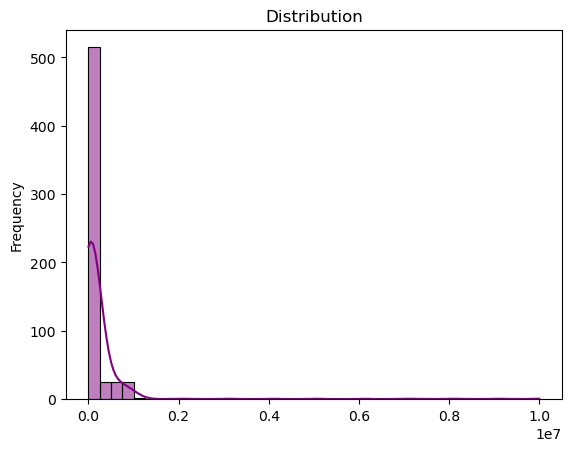

In [17]:
_plot_dist(exog_savings_grid)

# Call DCEGM

In [ ]:
(
    state_space,
    map_state_to_state_space_index,
    states_names_without_exog,
    exog_state_names,
    n_exog_states,
    exog_state_space,
) = create_state_space(options)

solve_func = get_solve_function(
    options=options,
    exog_savings_grid=exog_savings_grid,
    utility_functions=utility_functions,
    final_period_functions=utility_functions_final_period,
    budget_constraint=budget_constraint,
    state_space_functions=state_space_functions,
)